In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb


In [2]:
data = pd.read_csv("Liver_disease_data.csv")

print("Dataset Shape:", data.shape)
data.head()

Dataset Shape: (1700, 11)


,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,0,35.857584,17.272828,0,1,0.658940,0,0,42.734240,1
1,71,1,30.732470,2.201266,0,1,1.670557,1,0,67.309822,1
2,48,0,19.971407,18.500944,0,0,9.928308,0,0,63.738956,0
3,34,1,16.615417,12.632870,0,0,5.630129,0,0,64.555873,1
4,62,1,16.065830,1.087815,0,1,3.566218,1,0,77.868689,1


Class Distribution:
 Diagnosis
1    0.550588
0    0.449412
Name: proportion, dtype: float64


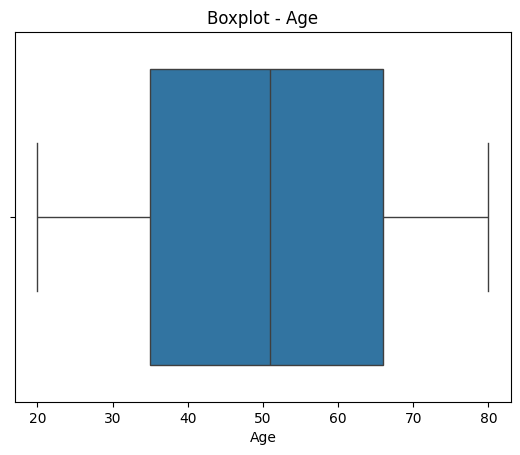

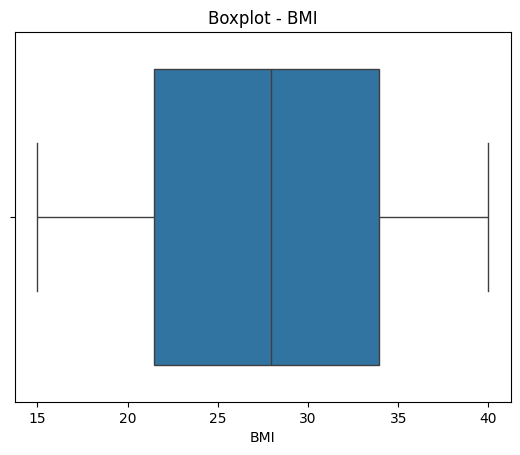

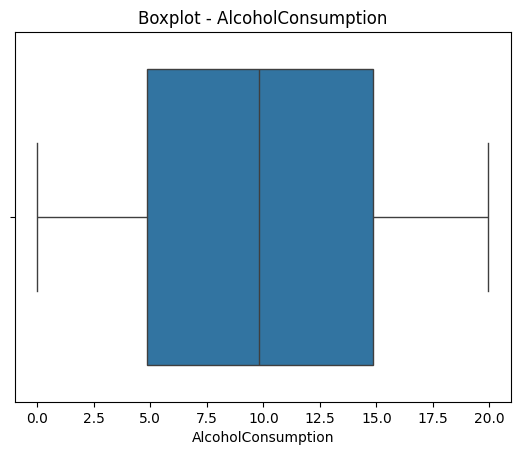

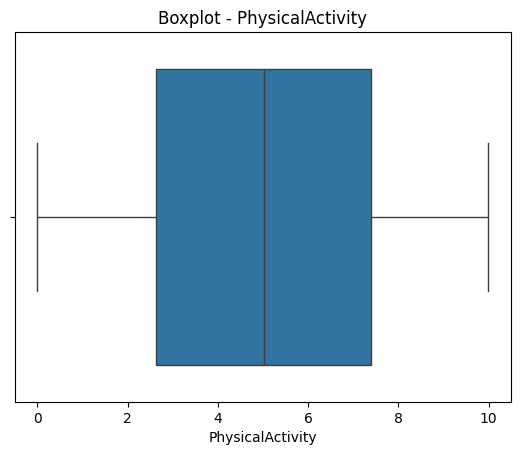

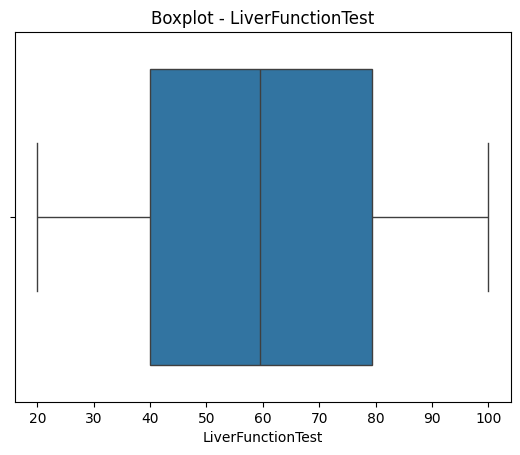

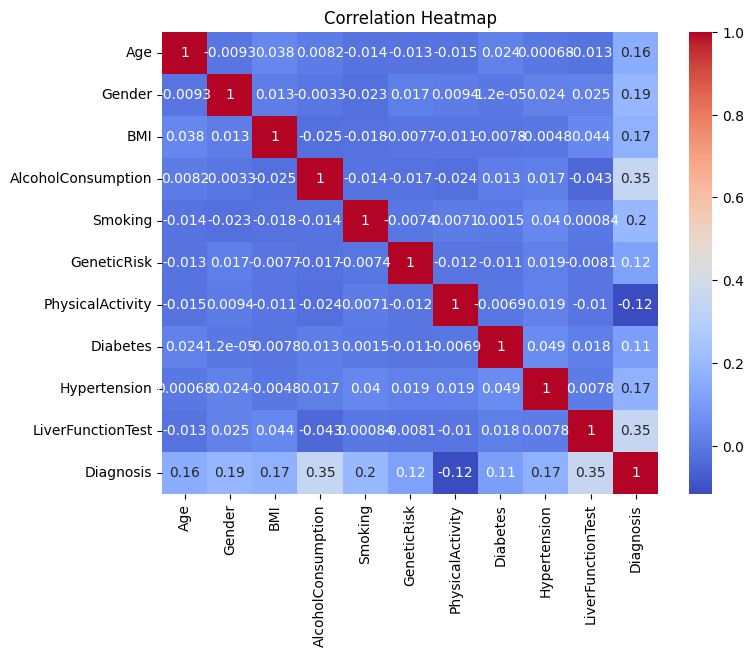

In [3]:
# Class distribution
print("Class Distribution:\n", data["Diagnosis"].value_counts(normalize=True))

# Boxplots
num_cols = ["Age", "BMI", "AlcoholConsumption", "PhysicalActivity", "LiverFunctionTest"]
for col in num_cols:
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot - {col}")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [4]:
# Handle missing values
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if data[col].dtype == 'object':
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            data[col].fillna(data[col].median(), inplace=True)

# Outlier treatment (IQR method)
for col in num_cols:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    data[col] = np.where(data[col] < lower, lower, data[col])
    data[col] = np.where(data[col] > upper, upper, data[col])


In [5]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X["BMI_Age_Ratio"] = X["BMI"] / (X["Age"] + 1)
        X["HeavyDrinker"] = (X["AlcoholConsumption"] > 14).astype(int)
        X["Risk_Smoke_Alcohol"] = X["Smoking"] * X["AlcoholConsumption"]
        return X


In [8]:
X = data.drop("Diagnosis", axis=1)
y = data["Diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Save raw test data for later use
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv("test_data_for_prediction.csv", index=False)

from google.colab import files
files.download("test_data_for_prediction.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "LightGBM": lgb.LGBMClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

param_grids = {
    "LogisticRegression": {'clf__C':[0.01,0.1,1,10], 'clf__penalty':['l1','l2'], 'clf__solver':['liblinear']},
    "RandomForest": {'clf__n_estimators':[100,200], 'clf__max_depth':[5,10,None], 'clf__min_samples_split':[2,5]},
    "GradientBoosting": {'clf__n_estimators':[100,200], 'clf__learning_rate':[0.05,0.1], 'clf__max_depth':[3,5]},
    "XGBoost": {'clf__n_estimators':[100,200], 'clf__learning_rate':[0.05,0.1], 'clf__max_depth':[3,5]},
    "LightGBM": {'clf__n_estimators':[100,200], 'clf__learning_rate':[0.05,0.1], 'clf__num_leaves':[31,63]},
    "SVM": {'clf__C':[0.1,1,10], 'clf__kernel':['linear','rbf']},
    "KNN": {'clf__n_neighbors':[3,5,7], 'clf__weights':['uniform','distance']}
}




🔎 Tuning LogisticRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best Params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
CV ROC AUC: 0.889
Test ROC AUC: 0.885
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       153
           1       0.82      0.78      0.80       187

    accuracy                           0.79       340
   macro avg       0.78      0.79      0.78       340
weighted avg       0.79      0.79      0.79       340



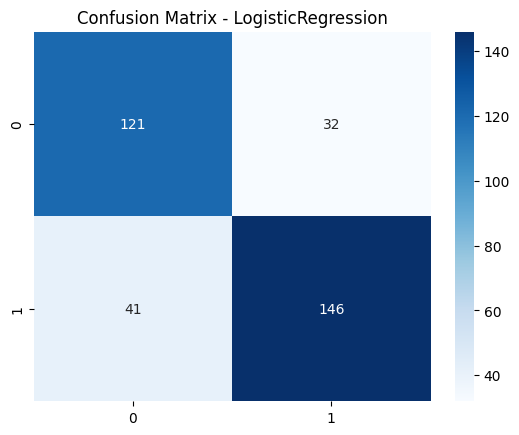

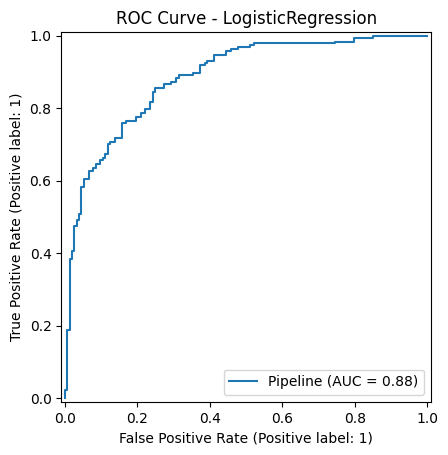


🔎 Tuning RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best Params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
CV ROC AUC: 0.918
Test ROC AUC: 0.933
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       153
           1       0.91      0.84      0.88       187

    accuracy                           0.87       340
   macro avg       0.87      0.87      0.87       340
weighted avg       0.87      0.87      0.87       340



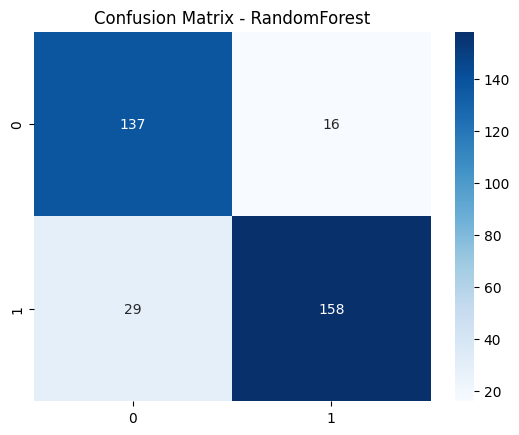

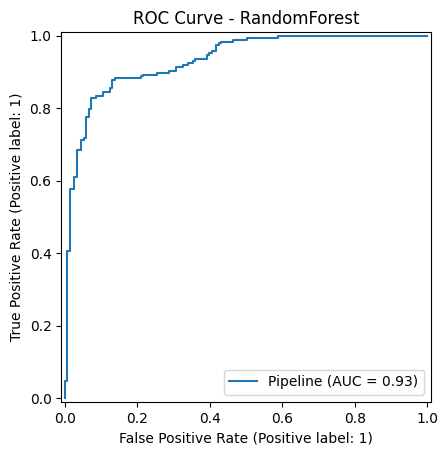


🔎 Tuning GradientBoosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best Params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200}
CV ROC AUC: 0.918
Test ROC AUC: 0.939
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       153
           1       0.89      0.83      0.86       187

    accuracy                           0.85       340
   macro avg       0.85      0.85      0.85       340
weighted avg       0.85      0.85      0.85       340



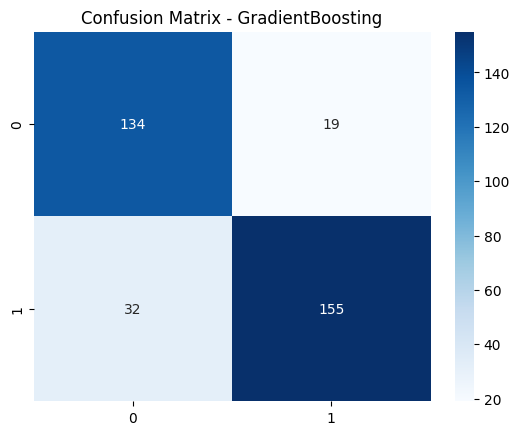

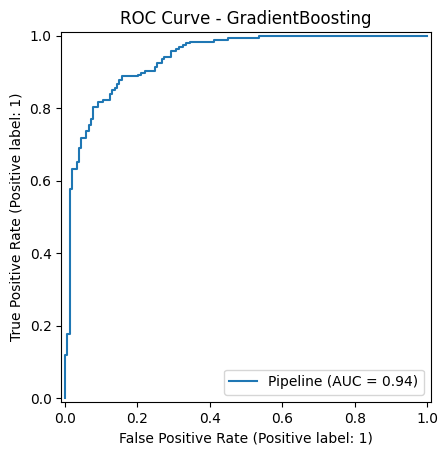


🔎 Tuning XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:15:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best Params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200}
CV ROC AUC: 0.922
Test ROC AUC: 0.941
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       153
           1       0.92      0.87      0.89       187

    accuracy                           0.88       340
   macro avg       0.88      0.88      0.88       340
weighted avg       0.88      0.88      0.88       340



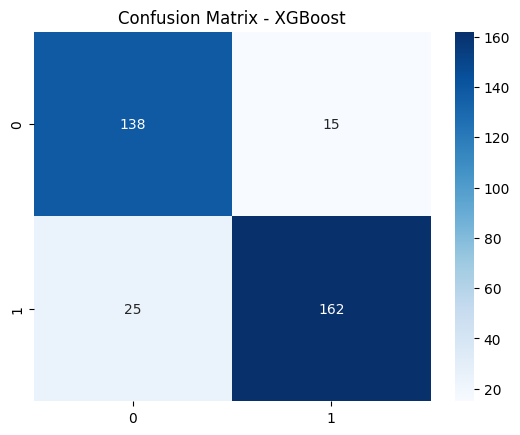

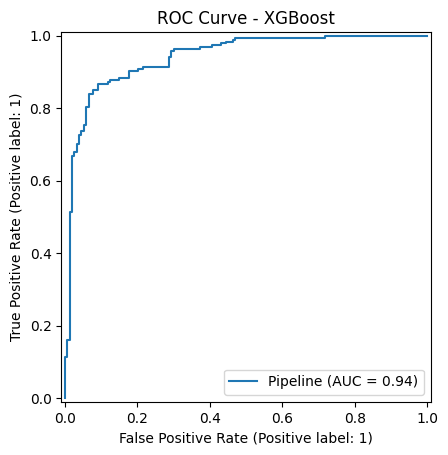


🔎 Tuning LightGBM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 749, number of negative: 611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 1360, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550735 -> initscore=0.203642
[LightGBM] [Info] Start training from score 0.203642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


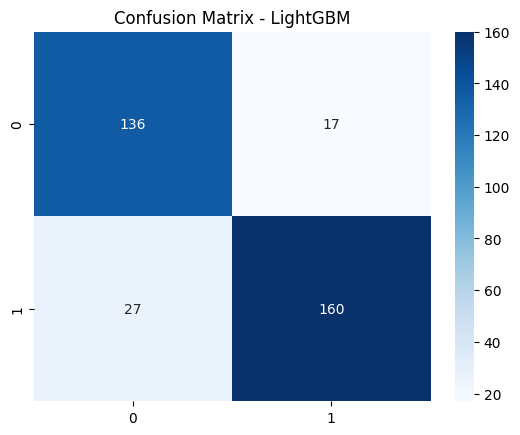

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


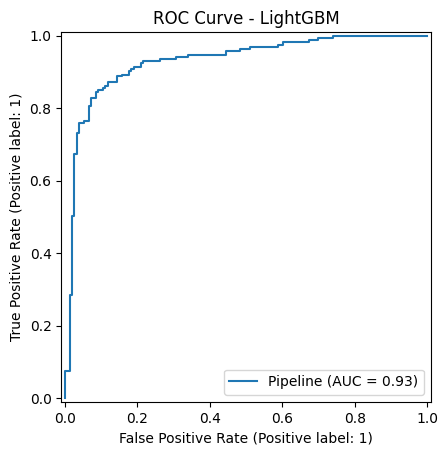


🔎 Tuning SVM...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Params: {'clf__C': 1, 'clf__kernel': 'rbf'}
CV ROC AUC: 0.898
Test ROC AUC: 0.909
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       153
           1       0.85      0.81      0.83       187

    accuracy                           0.82       340
   macro avg       0.82      0.82      0.82       340
weighted avg       0.82      0.82      0.82       340



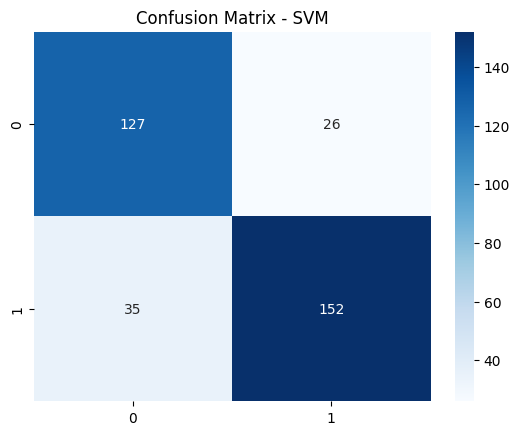

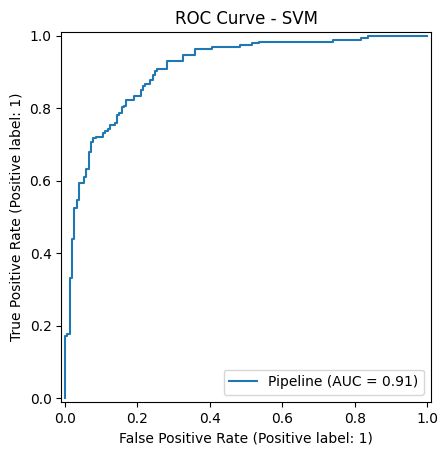


🔎 Tuning KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✅ Best Params: {'clf__n_neighbors': 7, 'clf__weights': 'distance'}
CV ROC AUC: 0.876
Test ROC AUC: 0.884
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       153
           1       0.85      0.81      0.83       187

    accuracy                           0.82       340
   macro avg       0.82      0.82      0.82       340
weighted avg       0.82      0.82      0.82       340



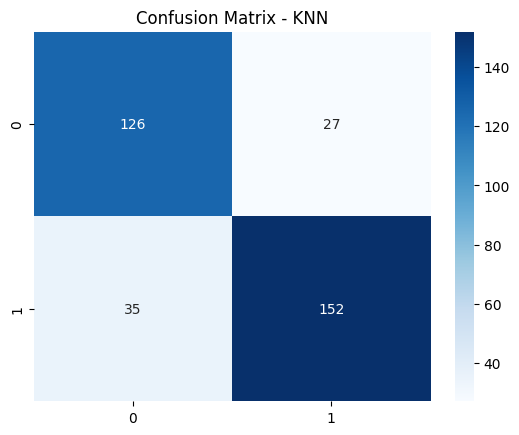

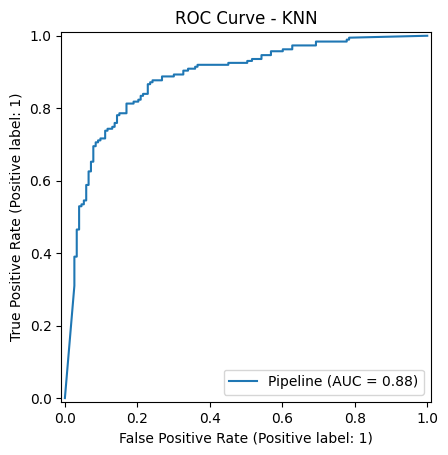

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('feat_eng', FeatureEngineer()),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=10)),
        ('clf', model)
    ])

    print(f"\n Tuning {name}...")
    grid = GridSearchCV(pipe, param_grids[name], scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)

    best_pipe = grid.best_estimator_
    y_pred = best_pipe.predict(X_test)
    y_proba = best_pipe.predict_proba(X_test)[:,1]

    auc = roc_auc_score(y_test, y_proba)
    results[name] = {
        "Best_Params": grid.best_params_,
        "CV_ROC_AUC": grid.best_score_,
        "Test_ROC_AUC": auc,
        "Model": best_pipe
    }

    print(f" Best Params: {grid.best_params_}")
    print(f"CV ROC AUC: {grid.best_score_:.3f}")
    print(f"Test ROC AUC: {auc:.3f}")

    # Evaluation
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
    plt.title(f"ROC Curve - {name}")
    plt.show()


In [11]:
best_model_name = max(results, key=lambda x: results[x]["Test_ROC_AUC"])
best_pipeline = results[best_model_name]["Model"]

print("🏆 Best Model:", best_model_name)
print("Best Parameters:", results[best_model_name]["Best_Params"])

# Refit pipeline on full training set to remove GridSearchCV artifacts
best_pipeline.fit(X_train, y_train)

# Save with joblib
joblib_file = "best_liver_model_joblib.pkl"
joblib.dump(best_pipeline, joblib_file)

from google.colab import files
files.download(joblib_file)


🏆 Best Model: XGBoost
Best Parameters: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 200}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:15:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 Final Test Performance
Accuracy  : 0.882
Precision : 0.915
Recall    : 0.866
F1 Score  : 0.890
ROC AUC   : 0.941

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       153
           1       0.92      0.87      0.89       187

    accuracy                           0.88       340
   macro avg       0.88      0.88      0.88       340
weighted avg       0.88      0.88      0.88       340



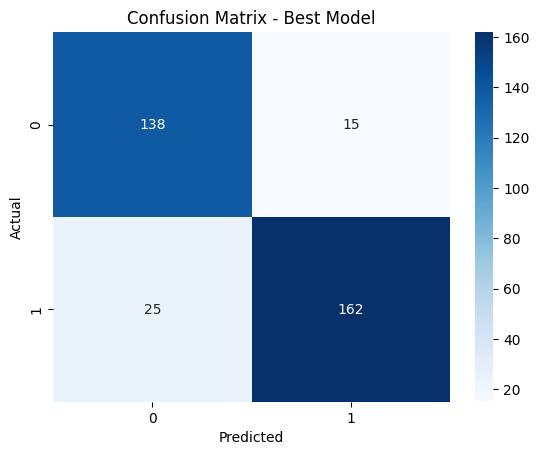

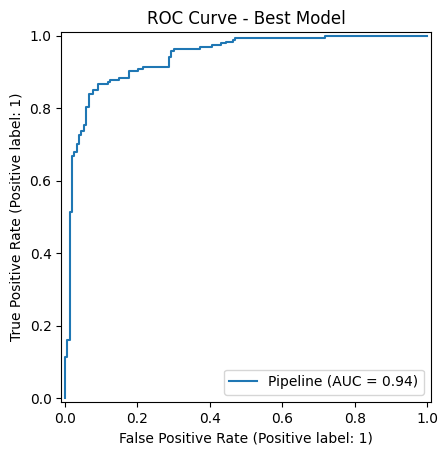

In [12]:
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("📊 Final Test Performance")
print(f"Accuracy  : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1 Score  : {f1:.3f}")
print(f"ROC AUC   : {roc_auc:.3f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Model")
plt.show()
RocCurveDisplay.from_estimator(best_pipeline, X_test, y_test)
plt.title("ROC Curve - Best Model")
plt.show()
